In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import pyplot_themes as themes

In [3]:
# themes.theme_dark()

In [4]:
data = pd.read_csv('./compression-data.csv', sep=';')

In [5]:
data = data.sort_values('cells')
#data = data[data['cells'] > 0]
fulldata = data
data

,cells,bytes,build_duration_nanosec,build_duration_total_nanosec,retr_duration_avg_nanosec,algorithm,table
338,87477,6132832,5073659,6442853031,512,baseline,main_tokenized_embedding
269,101457,6212128,5852510,7464257664,517,baseline,main_tokenized
75,112939,6293920,6522988,8411165898,557,baseline,cocoa_main_tokenized
560,275316,30312368,19166852,26599863984,814,baseline,open_data_mate_main_tokenized
339,439667,25881896,24990790,6842679602,605,baseline,main_tokenized_embedding
...,...,...,...,...,...,...,...
182,1587092403,147625032640,96416031645,1503080298922,5540,baseline,gittables_main_tokenized
180,1588021298,147661105256,95772541057,1469776021065,5536,baseline,gittables_main_tokenized
213,1588021298,42180820864,128995117730,431698462755,3241,dedup_btree,gittables_main_tokenized
240,1588021298,39465052304,147221973909,467141792557,814,dedup_hash,gittables_main_tokenized


In [6]:
c = {
    'ns': 'red',
    'baseline': 'blue',
    'dedup_hash': 'orange',
    'dedup_btree': 'violet',
}   


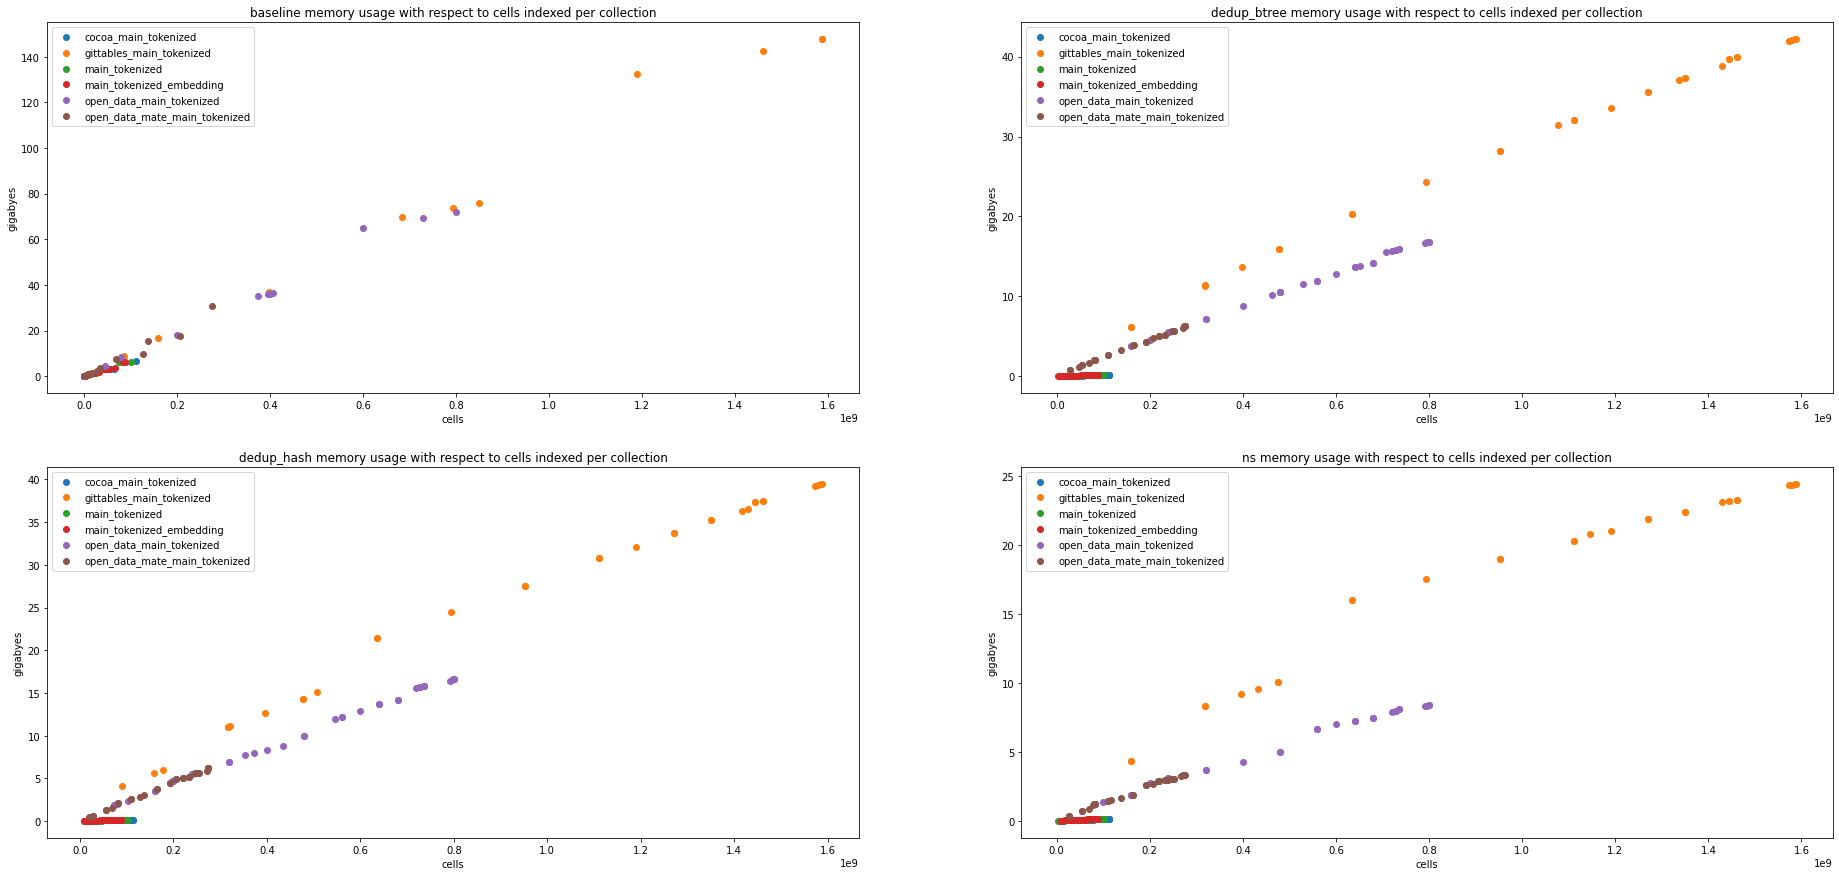

In [7]:
fig, [[baseline, dt], [dh, ns]] = plt.subplots(2,2, figsize=(32, 15))

data['bytes_gb'] = data["bytes"] * 1e-9

for [pt, id] in [(baseline, "baseline"), (dt, "dedup_btree"), (dh, "dedup_hash"), (ns, "ns")]:

    pt.set_title(id + " memory usage with respect to cells indexed per collection")
    pt.set_xlabel("cells")
    pt.set_ylabel("gigabyes")

    for t, row in data[data['algorithm'] == id].groupby("table"):
        pt.scatter("cells", "bytes_gb", data=row, label=t)


    pt.legend()


Text(0.5, 1.0, 'index duration per collection')

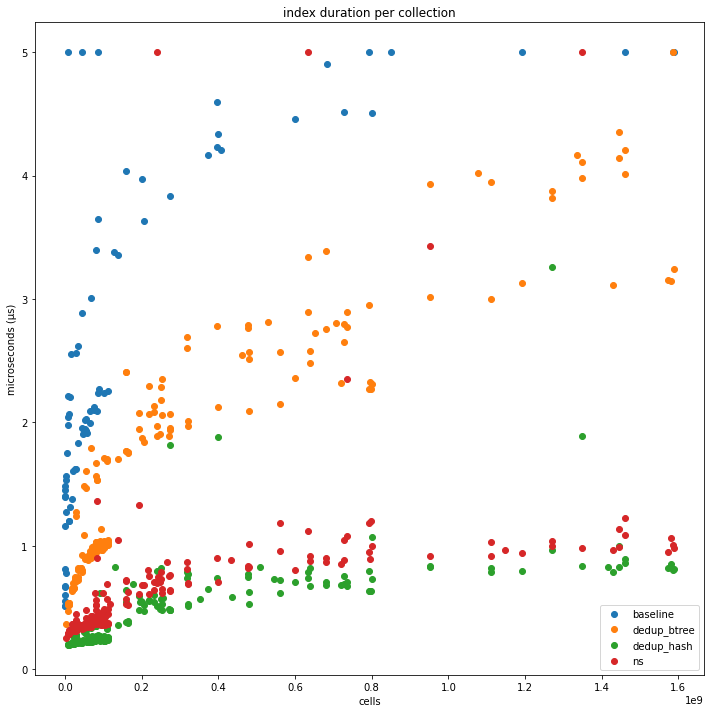

In [12]:

fig, ax = plt.subplots(figsize=(12, 12))

data['retr_duration_avg_microsec'] = data['retr_duration_avg_nanosec'] / 1000

data['retr_duration_avg_microsec_capped'] = np.array([min(5.0, elem) for elem in data['retr_duration_avg_microsec']])

for algo, row in data.groupby("algorithm"):

    ax.scatter('cells', 'retr_duration_avg_microsec_capped', data=row, label=algo)


ax.legend()
ax.set_ylabel('microseconds (μs)')
ax.set_xlabel('cells')
ax.set_title("index duration per collection")



Hash vs BTree

The algorithms are heavily similar in buildtime and memory usage, but indexing into some hashmap is SIGNIFICANTLY faster.


# Spikes

Spikes during retrieval / indexing are relatively easy to explain, when looking at the data.

The key we index is sampled at random, chosen with each distinct key having the same probability to be picked.
However, some keys, e.g. cell values, make up more than 95% (check that number, e.g. main_tokenized an "0") of the entire dictionary.

That means we have to decode/copy an insane amount of values when indexing for a select few keys.

That makes the index time wildly hard to predict.

## TODO 

- investigate relation between cardinality and access time
- investigate relation between cardinality and difference in compression (baseline vs dedup)

Text(0.5, 1.0, 'build time per algorithm')

<Figure size 432x288 with 0 Axes>

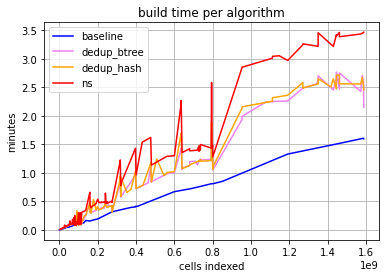

In [9]:
plt.figure(figsize=(6, 4))
fig, bta = plt.subplots()

data["build_duration_sec"] = data["build_duration_nanosec"] * 1e-9
data["build_duration_min"] = data["build_duration_sec"] / 60

for algo,row in data.groupby("algorithm"):
    p, = bta.plot('cells', 'build_duration_min', c=c[algo], data=row)
    p.set_label(algo)


bta.grid()
bta.set_xlabel('cells indexed')
bta.set_ylabel('minutes')
bta.legend()
bta.set_title("build time per algorithm")

Text(0.5, 1.0, 'memory per table')

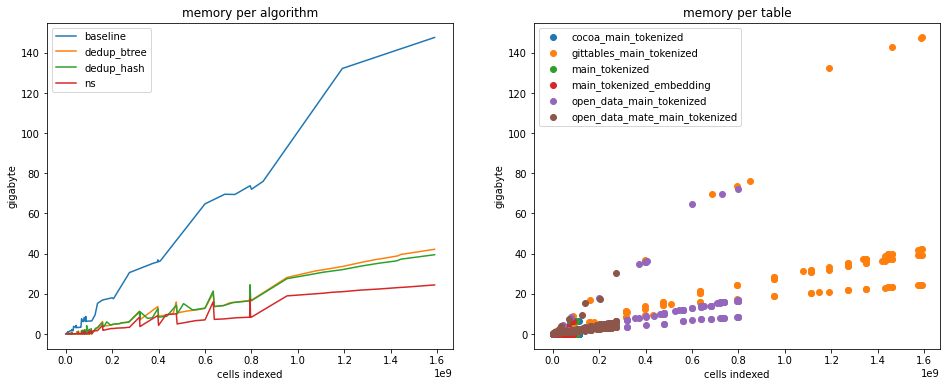

In [10]:
data['gigabyte'] = data['bytes'] / 1e9

fig,[mpa, mpt] = plt.subplots(1, 2, figsize=(16, 6))
for algo,row in data.groupby("algorithm"):
    p, = mpa.plot('cells', 'gigabyte',data=row)
    p.set_label(algo)
    # mpt.scatter('cells', 'gigabyte', data=row, label="")

mpa.set_xlabel('cells indexed')
mpa.set_ylabel('gigabyte')
mpa.legend()
mpa.set_title("memory per algorithm")

# now per table
#fig,mpt = plt.subplots(figsize=(16, 6))
for table,row in data.groupby("table"):
    p = mpt.scatter('cells', 'gigabyte', data=row)
    p.set_label(table)

mpt.set_xlabel('cells indexed')
mpt.set_ylabel('gigabyte')
mpt.legend()
mpt.set_title("memory per table")

go backl to survey paper
justify choices (what to test, what not to)
how can one combine these approaches

the memory footprint is not dependant on the dataset at hand, but rather the amount of data consumed and the algorithm presented